In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.metrics import roc_curve, auc
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from flask import Flask, render_template, request
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pickle
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

[0]	validation_0-logloss:0.62281
[99]	validation_0-logloss:0.22843
Accuracy: 0.8907112970711297

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      2735
           1       0.89      0.91      0.90      3240

    accuracy                           0.89      5975
   macro avg       0.89      0.89      0.89      5975
weighted avg       0.89      0.89      0.89      5975



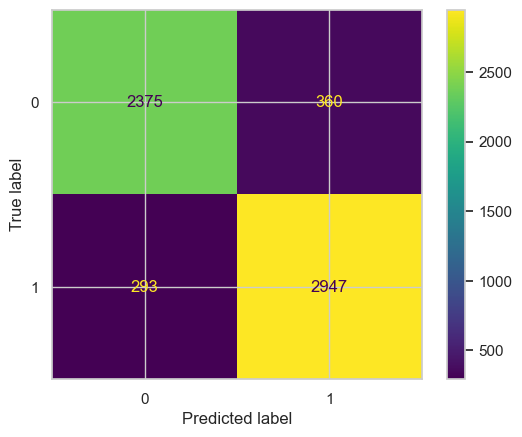

Best Iteration: 98
Mean Training Accuracy across 30 bootstraps: 0.9164546545038637
Mean Test Accuracy across 30 bootstraps: 0.8913082287308227
Mean Training Recall across 30 bootstraps: 0.9423553236233352
Mean Test Recall across 30 bootstraps: 0.9184259259259259
Mean Squared Error on Training Accuracy across 30 bootstraps: 0.006982817462494491
Mean Squared Error on Test Accuracy across 30 bootstraps: 0.01181764091431639
Mean Squared Error on Training Recall across 30 bootstraps: 0.0033553051346908455
Mean Squared Error on Test Recall across 30 bootstraps: 0.0066821654473403465
Cross-Validation Scores: [0.89372385 0.89351464 0.89393305 0.89328311 0.89684034]
Mean CV Score: 0.8942590009814555
Mean Squared Error on Holdout Set: 0.11129707112970712
Mean Squared Error on Training Set: 0.08113649677797305


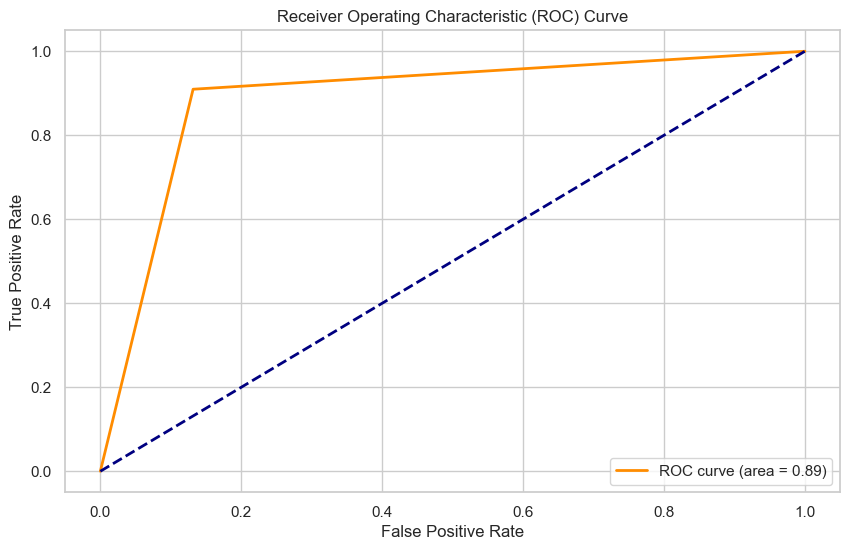

AUC-ROC: 0.8889704222809036


In [3]:
# XGBoost model

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load dataset, drop irrelevant columns, remove minus numerical values and label encode where necessary
df = pd.read_csv('churn.csv')
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])

target_variable = 'churn'

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Convert non-numeric columns to numeric
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop rows with missing values (NaNs) after conversion
df_encoded = df_encoded.dropna()

# Split the data into features and target variable
X = df_encoded.drop(columns=[target_variable])
y = df_encoded[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost classifier
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, objective='binary:logistic')

# Train the model on the training set
model.fit(X_train, y_train, eval_metric='logloss', eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=100)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

# Best interation
best_iteration = model.best_iteration
print(f"Best Iteration: {best_iteration}")

## Bootstrapping

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

# Number of bootstrap samples
num_bootstraps = 30

# Initialize empty lists to store accuracy and recall values for training and test sets
train_accuracy_values = []
mse_train_accuracy_values = []
train_recall_values = []
mse_train_recall_values = []
test_accuracy_values = []
mse_test_accuracy_values = []
test_recall_values = []
mse_test_recall_values = []

# Bootstrap loop
for _ in range(num_bootstraps):
    # Create a bootstrap sample for training
    bootstrap_sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap_train = X_train.iloc[bootstrap_sample_indices]
    y_bootstrap_train = y_train.iloc[bootstrap_sample_indices]

    model.fit(X_bootstrap_train, y_bootstrap_train)

    # Evaluate the model on the fixed training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    mse_train_accuracy = mean_squared_error([train_accuracy], [1])
    train_recall = recall_score(y_train, y_train_pred)
    mse_train_recall = mean_squared_error([train_recall], [1])
    train_accuracy_values.append(train_accuracy)
    mse_train_accuracy_values.append(mse_train_accuracy)
    train_recall_values.append(train_recall)
    mse_train_recall_values.append(mse_train_recall)

    # Evaluate the model on the fixed test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mse_test_accuracy = mean_squared_error([test_accuracy], [1])
    test_recall = recall_score(y_test, y_test_pred)
    mse_test_recall = mean_squared_error([test_recall], [1])
    test_accuracy_values.append(test_accuracy)
    mse_test_accuracy_values.append(mse_test_accuracy)
    test_recall_values.append(test_recall)
    mse_test_recall_values.append(mse_test_recall)

# Calculate means for training and test sets
mean_train_accuracy = np.mean(train_accuracy_values)
mse_mean_train_accuracy = np.mean(mse_train_accuracy_values)
mean_train_recall = np.mean(train_recall_values)
mse_mean_train_recall = np.mean(mse_train_recall_values)
mean_test_accuracy = np.mean(test_accuracy_values)
mse_mean_test_accuracy = np.mean(mse_test_accuracy_values)
mean_test_recall = np.mean(test_recall_values)
mse_mean_test_recall = np.mean(mse_test_recall_values)


print(f"Mean Training Accuracy across {num_bootstraps} bootstraps: {mean_train_accuracy}")
print(f"Mean Test Accuracy across {num_bootstraps} bootstraps: {mean_test_accuracy}")
print(f"Mean Training Recall across {num_bootstraps} bootstraps: {mean_train_recall}")
print(f"Mean Test Recall across {num_bootstraps} bootstraps: {mean_test_recall}")
print(f"Mean Squared Error on Training Accuracy across {num_bootstraps} bootstraps: {mse_mean_train_accuracy}")
print(f"Mean Squared Error on Test Accuracy across {num_bootstraps} bootstraps: {mse_mean_test_accuracy}")
print(f"Mean Squared Error on Training Recall across {num_bootstraps} bootstraps: {mse_mean_train_recall}")
print(f"Mean Squared Error on Test Recall across {num_bootstraps} bootstraps: {mse_mean_test_recall}")

from sklearn.model_selection import StratifiedKFold, cross_val_score

## K-Fold CV

k_folds = 5
stratified_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print or use the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

## Validation with holdout data set

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on the holdout set
y_pred_holdout = model.predict(X_holdout)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Evaluate the model on the holdout set
mse_holdout = mean_squared_error(y_holdout, y_pred_holdout)
print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error on Training Set: {mse_train}')

## Area under the curve/ROC

# Assuming 'y_true' contains true labels and 'y_scores' contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('AUC-ROC:', roc_auc)

Training on fold [0/5]

bestTest = 0.2308277736
bestIteration = 97

Training on fold [1/5]

bestTest = 0.2292661349
bestIteration = 98

Training on fold [2/5]

bestTest = 0.2214078506
bestIteration = 99

Training on fold [3/5]

bestTest = 0.2233017832
bestIteration = 99

Training on fold [4/5]

bestTest = 0.2326604859
bestIteration = 97

0:	learn: 0.6314974	test: 0.6313780	best: 0.6313780 (0)	total: 27.9ms	remaining: 2.76s
99:	learn: 0.2234358	test: 0.2306513	best: 0.2306513 (99)	total: 2.67s	remaining: 0us

bestTest = 0.2306513076
bestIteration = 99

Accuracy: 0.8955648535564854

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      2735
           1       0.90      0.91      0.90      3240

    accuracy                           0.90      5975
   macro avg       0.90      0.89      0.89      5975
weighted avg       0.90      0.90      0.90      5975



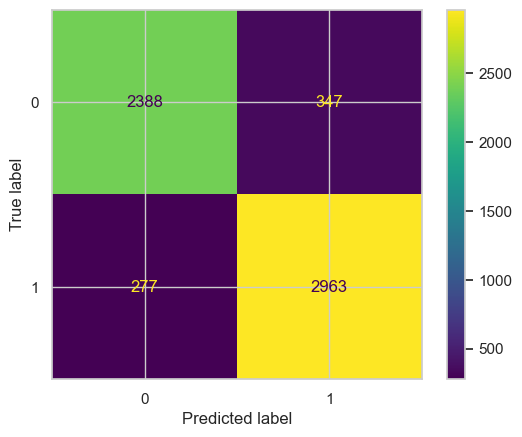


Overfitting Detector: 1.0
Mean Training Accuracy across 30 bootstraps: 0.9017965241163836
Mean Test Accuracy across 30 bootstraps: 0.8941032078103207
Mean Training Recall across 30 bootstraps: 0.9214087286133396
Mean Test Recall across 30 bootstraps: 0.914650205761317
Mean Squared Error on Training Accuracy across 30 bootstraps: 0.009645349679069439
Mean Squared Error on Test Accuracy across 30 bootstraps: 0.011216378798223653
Mean Squared Error on Training Recall across 30 bootstraps: 0.006192819638635958
Mean Squared Error on Test Recall across 30 bootstraps: 0.007304647411471827
Cross-Validation Scores: [0.89414226 0.89225941 0.89518828 0.89788659 0.89746809]
Mean CV Score: 0.895388926973921
Mean Squared Error on Holdout Set: 0.10610878661087866
Mean Squared Error on Training Set: 0.09925516779646833


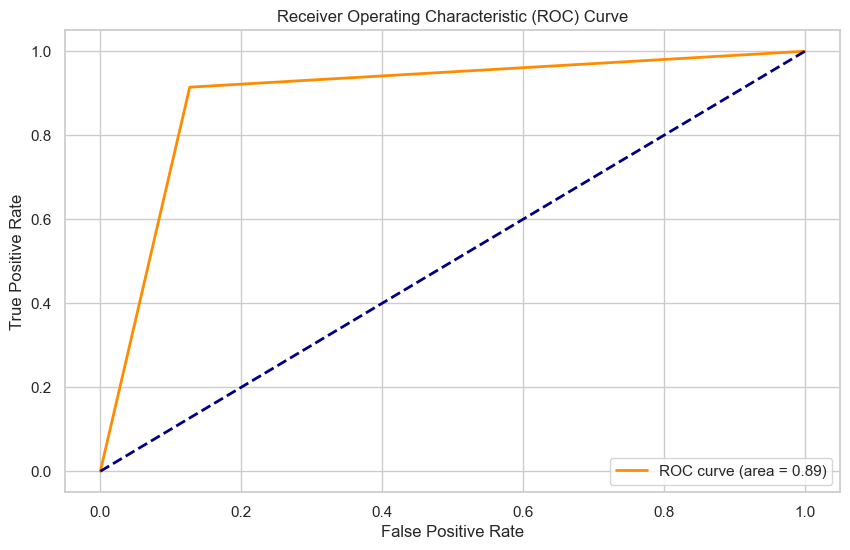

AUC-ROC: 0.8938161577177421


In [4]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder

## CatBoost model

# Load dataset, drop irrelevant columns, remove minus numerical values and label encode where necessary
df = pd.read_csv('churn.csv')
# Drop referral_id for irrelevancy, and past_complaint, complaint status to prevent data leakage
df.drop(['referral_id', 'past_complaint', 'complaint_status'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])


target_variable = 'churn'

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Split the data into features and target variable
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost classifier
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=False, loss_function='Logloss', cat_features=categorical_features)

# Use cross-validation with the train-test split
cv_params = model.get_params()
cv_data = cv(Pool(X, y, cat_features=categorical_features), cv_params, fold_count=5)

# Train the model on the training set
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

# Overfitting detector
overfitting_detector = model.get_best_iteration() / (cv_data.shape[0] - 1)

print(f"\nOverfitting Detector: {overfitting_detector}")

## Bootstrapping

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

# Number of bootstrap samples
num_bootstraps = 30

# Initialize empty lists to store accuracy and recall values for training and test sets
train_accuracy_values = []
mse_train_accuracy_values = []
train_recall_values = []
mse_train_recall_values = []
test_accuracy_values = []
mse_test_accuracy_values = []
test_recall_values = []
mse_test_recall_values = []

# Bootstrap loop
for _ in range(num_bootstraps):
    # Create a bootstrap sample for training
    bootstrap_sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap_train = X_train.iloc[bootstrap_sample_indices]
    y_bootstrap_train = y_train.iloc[bootstrap_sample_indices]

    model.fit(X_bootstrap_train, y_bootstrap_train)

    # Evaluate the model on the fixed training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    mse_train_accuracy = mean_squared_error([train_accuracy], [1])
    train_recall = recall_score(y_train, y_train_pred)
    mse_train_recall = mean_squared_error([train_recall], [1])
    train_accuracy_values.append(train_accuracy)
    mse_train_accuracy_values.append(mse_train_accuracy)
    train_recall_values.append(train_recall)
    mse_train_recall_values.append(mse_train_recall)

    # Evaluate the model on the fixed test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mse_test_accuracy = mean_squared_error([test_accuracy], [1])
    test_recall = recall_score(y_test, y_test_pred)
    mse_test_recall = mean_squared_error([test_recall], [1])
    test_accuracy_values.append(test_accuracy)
    mse_test_accuracy_values.append(mse_test_accuracy)
    test_recall_values.append(test_recall)
    mse_test_recall_values.append(mse_test_recall)

# Calculate means for training and test sets
mean_train_accuracy = np.mean(train_accuracy_values)
mse_mean_train_accuracy = np.mean(mse_train_accuracy_values)
mean_train_recall = np.mean(train_recall_values)
mse_mean_train_recall = np.mean(mse_train_recall_values)
mean_test_accuracy = np.mean(test_accuracy_values)
mse_mean_test_accuracy = np.mean(mse_test_accuracy_values)
mean_test_recall = np.mean(test_recall_values)
mse_mean_test_recall = np.mean(mse_test_recall_values)


print(f"Mean Training Accuracy across {num_bootstraps} bootstraps: {mean_train_accuracy}")
print(f"Mean Test Accuracy across {num_bootstraps} bootstraps: {mean_test_accuracy}")
print(f"Mean Training Recall across {num_bootstraps} bootstraps: {mean_train_recall}")
print(f"Mean Test Recall across {num_bootstraps} bootstraps: {mean_test_recall}")
print(f"Mean Squared Error on Training Accuracy across {num_bootstraps} bootstraps: {mse_mean_train_accuracy}")
print(f"Mean Squared Error on Test Accuracy across {num_bootstraps} bootstraps: {mse_mean_test_accuracy}")
print(f"Mean Squared Error on Training Recall across {num_bootstraps} bootstraps: {mse_mean_train_recall}")
print(f"Mean Squared Error on Test Recall across {num_bootstraps} bootstraps: {mse_mean_test_recall}")

## K-Fold CV

from sklearn.model_selection import StratifiedKFold, cross_val_score

k_folds = 5
stratified_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print or use the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

## Validation with holdout data set

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on the holdout set
y_pred_holdout = model.predict(X_holdout)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Evaluate the model on the holdout set
mse_holdout = mean_squared_error(y_holdout, y_pred_holdout)
print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error on Training Set: {mse_train}')

## Area under the curve/ROC

# Assuming 'y_true' contains true labels and 'y_scores' contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('AUC-ROC:', roc_auc)

Accuracy: 0.7802510460251046

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77      2735
           1       0.81      0.77      0.79      3240

    accuracy                           0.78      5975
   macro avg       0.78      0.78      0.78      5975
weighted avg       0.78      0.78      0.78      5975



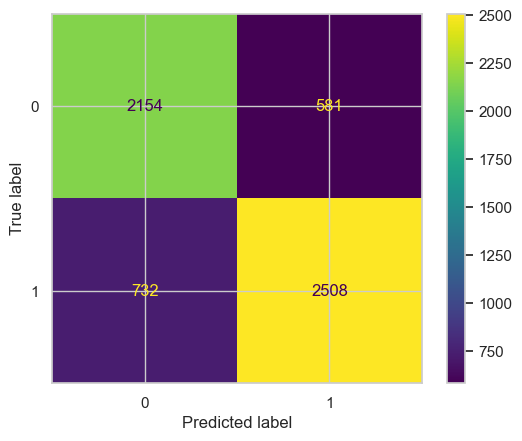

Mean Training Accuracy across 30 bootstraps: 0.7789968477138952
Mean Test Accuracy across 30 bootstraps: 0.7791966527196652
Mean Training Recall across 30 bootstraps: 0.7760183814938857
Mean Test Recall across 30 bootstraps: 0.7731790123456791
Mean Squared Error on Training Accuracy across 30 bootstraps: 0.048844010478386296
Mean Squared Error on Test Accuracy across 30 bootstraps: 0.048755619824582895
Mean Squared Error on Training Recall across 30 bootstraps: 0.05018065233522326
Mean Squared Error on Test Recall across 30 bootstraps: 0.051460737057359145
Cross-Validation Scores: [0.77280335 0.77384937 0.77217573 0.7911697  0.78363674]
Mean CV Score: 0.7787269793491575
Mean Squared Error on Holdout Set: 0.2197489539748954
Mean Squared Error on Training Set: 0.220102100594192


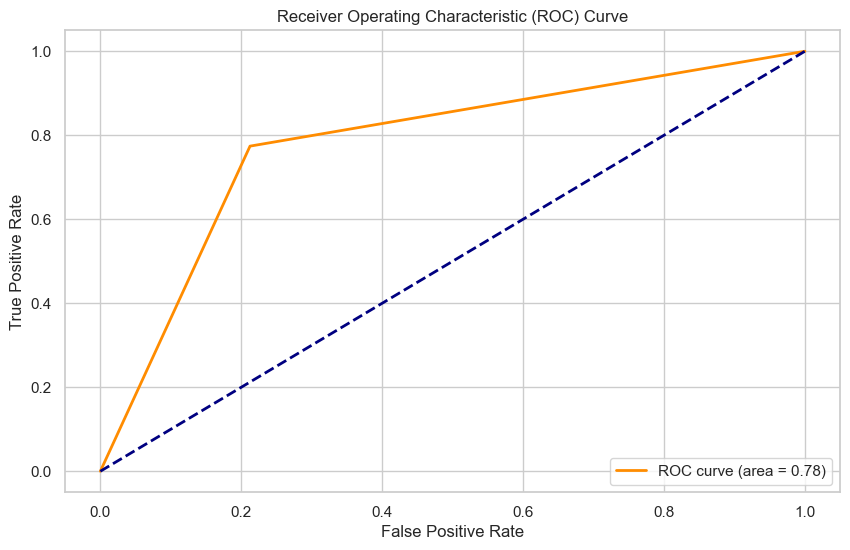

AUC-ROC: 0.780821314916379


In [5]:
## Test against baseline logistic regression model

# Load dataset, drop irrelevant columns, remove minus numerical values and label encode where necessary
df = pd.read_csv('churn.csv')
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])

target_variable = 'churn'

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Convert non-numeric columns to numeric
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop rows with missing values (NaNs) after conversion
df_encoded = df_encoded.dropna()

# Split the data into features and target variable
X = df_encoded.drop(columns=[target_variable])
y = df_encoded[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

## Bootstrapping

# Number of bootstrap samples
num_bootstraps = 30

# Initialize empty lists to store accuracy and recall values for training and test sets
train_accuracy_values = []
mse_train_accuracy_values = []
train_recall_values = []
mse_train_recall_values = []
test_accuracy_values = []
mse_test_accuracy_values = []
test_recall_values = []
mse_test_recall_values = []

# Bootstrap loop
for _ in range(num_bootstraps):
    # Create a bootstrap sample for training
    bootstrap_sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap_train = X_train.iloc[bootstrap_sample_indices]
    y_bootstrap_train = y_train.iloc[bootstrap_sample_indices]

    model.fit(X_bootstrap_train, y_bootstrap_train)

    # Evaluate the model on the fixed training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    mse_train_accuracy = mean_squared_error([train_accuracy], [1])
    train_recall = recall_score(y_train, y_train_pred)
    mse_train_recall = mean_squared_error([train_recall], [1])
    train_accuracy_values.append(train_accuracy)
    mse_train_accuracy_values.append(mse_train_accuracy)
    train_recall_values.append(train_recall)
    mse_train_recall_values.append(mse_train_recall)

    # Evaluate the model on the fixed test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mse_test_accuracy = mean_squared_error([test_accuracy], [1])
    test_recall = recall_score(y_test, y_test_pred)
    mse_test_recall = mean_squared_error([test_recall], [1])
    test_accuracy_values.append(test_accuracy)
    mse_test_accuracy_values.append(mse_test_accuracy)
    test_recall_values.append(test_recall)
    mse_test_recall_values.append(mse_test_recall)

# Calculate means for training and test sets
mean_train_accuracy = np.mean(train_accuracy_values)
mse_mean_train_accuracy = np.mean(mse_train_accuracy_values)
mean_train_recall = np.mean(train_recall_values)
mse_mean_train_recall = np.mean(mse_train_recall_values)
mean_test_accuracy = np.mean(test_accuracy_values)
mse_mean_test_accuracy = np.mean(mse_test_accuracy_values)
mean_test_recall = np.mean(test_recall_values)
mse_mean_test_recall = np.mean(mse_test_recall_values)


print(f"Mean Training Accuracy across {num_bootstraps} bootstraps: {mean_train_accuracy}")
print(f"Mean Test Accuracy across {num_bootstraps} bootstraps: {mean_test_accuracy}")
print(f"Mean Training Recall across {num_bootstraps} bootstraps: {mean_train_recall}")
print(f"Mean Test Recall across {num_bootstraps} bootstraps: {mean_test_recall}")
print(f"Mean Squared Error on Training Accuracy across {num_bootstraps} bootstraps: {mse_mean_train_accuracy}")
print(f"Mean Squared Error on Test Accuracy across {num_bootstraps} bootstraps: {mse_mean_test_accuracy}")
print(f"Mean Squared Error on Training Recall across {num_bootstraps} bootstraps: {mse_mean_train_recall}")
print(f"Mean Squared Error on Test Recall across {num_bootstraps} bootstraps: {mse_mean_test_recall}")

from sklearn.model_selection import StratifiedKFold, cross_val_score

## K-Fold CV

k_folds = 5
stratified_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print or use the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

## Validation with holdout data set

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on the holdout set
y_pred_holdout = model.predict(X_holdout)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Evaluate the model on the holdout set
mse_holdout = mean_squared_error(y_holdout, y_pred_holdout)
print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error on Training Set: {mse_train}')

## Area under the curve/ROC

# Assuming 'y_true' contains true labels and 'y_scores' contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('AUC-ROC:', roc_auc)

Accuracy: 0.8672803347280335

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      2735
           1       0.91      0.84      0.87      3240

    accuracy                           0.87      5975
   macro avg       0.87      0.87      0.87      5975
weighted avg       0.87      0.87      0.87      5975



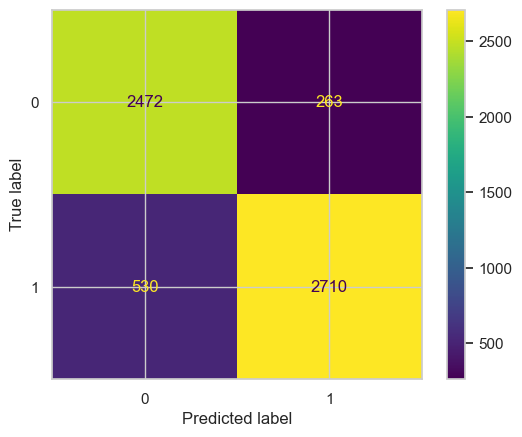

Mean Training Accuracy across 30 bootstraps: 0.8723909950623486
Mean Test Accuracy across 30 bootstraps: 0.8666108786610877
Mean Training Recall across 30 bootstraps: 0.838577770854428
Mean Test Recall across 30 bootstraps: 0.8351440329218106
Mean Squared Error on Training Accuracy across 30 bootstraps: 0.01628757589521416
Mean Squared Error on Test Accuracy across 30 bootstraps: 0.01779378185489283
Mean Squared Error on Training Recall across 30 bootstraps: 0.02607206883256554
Mean Squared Error on Test Recall across 30 bootstraps: 0.027185566224660878
Cross-Validation Scores: [0.86778243 0.86924686 0.86527197 0.87842645 0.87298598]
Mean CV Score: 0.8707427369217313
Mean Squared Error on Holdout Set: 0.13288702928870294
Mean Squared Error on Training Set: 0.12574273997824087


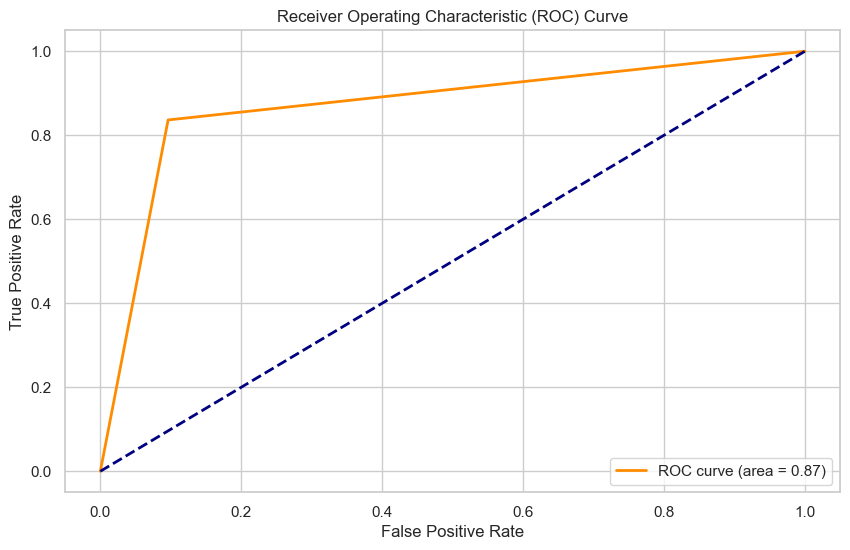

AUC-ROC: 0.8701294377863542


In [6]:
## Test against Random Forest model

# Load dataset, drop irrelevant columns, remove minus numerical values and label encode where necessary
df = pd.read_csv('churn.csv')
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])

target_variable = 'churn'

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Convert non-numeric columns to numeric
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop rows with missing values (NaNs) after conversion
df_encoded = df_encoded.dropna()

# Split the data into features and target variable
X = df_encoded.drop(columns=[target_variable])
y = df_encoded[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train), 

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

rf_classification_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

## Bootstrapping

# Number of bootstrap samples
num_bootstraps = 30

# Initialize empty lists to store accuracy and recall values for training and test sets
train_accuracy_values = []
mse_train_accuracy_values = []
train_recall_values = []
mse_train_recall_values = []
test_accuracy_values = []
mse_test_accuracy_values = []
test_recall_values = []
mse_test_recall_values = []

# Bootstrap loop
for _ in range(num_bootstraps):
    # Create a bootstrap sample for training
    bootstrap_sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap_train = X_train.iloc[bootstrap_sample_indices]
    y_bootstrap_train = y_train.iloc[bootstrap_sample_indices]

    model.fit(X_bootstrap_train, y_bootstrap_train)

    # Evaluate the model on the fixed training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    mse_train_accuracy = mean_squared_error([train_accuracy], [1])
    train_recall = recall_score(y_train, y_train_pred)
    mse_train_recall = mean_squared_error([train_recall], [1])
    train_accuracy_values.append(train_accuracy)
    mse_train_accuracy_values.append(mse_train_accuracy)
    train_recall_values.append(train_recall)
    mse_train_recall_values.append(mse_train_recall)

    # Evaluate the model on the fixed test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mse_test_accuracy = mean_squared_error([test_accuracy], [1])
    test_recall = recall_score(y_test, y_test_pred)
    mse_test_recall = mean_squared_error([test_recall], [1])
    test_accuracy_values.append(test_accuracy)
    mse_test_accuracy_values.append(mse_test_accuracy)
    test_recall_values.append(test_recall)
    mse_test_recall_values.append(mse_test_recall)

# Calculate means for training and test sets
mean_train_accuracy = np.mean(train_accuracy_values)
mse_mean_train_accuracy = np.mean(mse_train_accuracy_values)
mean_train_recall = np.mean(train_recall_values)
mse_mean_train_recall = np.mean(mse_train_recall_values)
mean_test_accuracy = np.mean(test_accuracy_values)
mse_mean_test_accuracy = np.mean(mse_test_accuracy_values)
mean_test_recall = np.mean(test_recall_values)
mse_mean_test_recall = np.mean(mse_test_recall_values)


print(f"Mean Training Accuracy across {num_bootstraps} bootstraps: {mean_train_accuracy}")
print(f"Mean Test Accuracy across {num_bootstraps} bootstraps: {mean_test_accuracy}")
print(f"Mean Training Recall across {num_bootstraps} bootstraps: {mean_train_recall}")
print(f"Mean Test Recall across {num_bootstraps} bootstraps: {mean_test_recall}")
print(f"Mean Squared Error on Training Accuracy across {num_bootstraps} bootstraps: {mse_mean_train_accuracy}")
print(f"Mean Squared Error on Test Accuracy across {num_bootstraps} bootstraps: {mse_mean_test_accuracy}")
print(f"Mean Squared Error on Training Recall across {num_bootstraps} bootstraps: {mse_mean_train_recall}")
print(f"Mean Squared Error on Test Recall across {num_bootstraps} bootstraps: {mse_mean_test_recall}")

from sklearn.model_selection import StratifiedKFold, cross_val_score

## K-Fold CV

k_folds = 5
stratified_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print or use the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

## Validation with holdout data set

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on the holdout set
y_pred_holdout = model.predict(X_holdout)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Evaluate the model on the holdout set
mse_holdout = mean_squared_error(y_holdout, y_pred_holdout)
print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error on Training Set: {mse_train}')

## Area under the curve/ROC

# Assuming 'y_true' contains true labels and 'y_scores' contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('AUC-ROC:', roc_auc)

In [7]:
df = pd.read_csv('churn.csv')
# Drop referral_id for irrelevancy, and past_complaint, complaint status to prevent data leakage
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Convert non-numeric columns to numeric
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop rows with missing values (NaNs) after conversion
df_encoded = df_encoded.dropna()
print(df_encoded.dtypes)

class_counts = df['churn'].value_counts()
print("Class Counts:")
print(class_counts)

total_instances = len(df)

class_balances = class_counts / total_instances * 100
print("Class Balances:")
print(class_balances)

age                                                int64
joining_date                                       int32
last_visit_time                                    int32
days_since_last_login                              int64
avg_time_spent                                     int64
opportunity_size_usd                               int64
avg_frequency_login_days                           int32
points_in_wallet                                   int64
churn                                              int64
technology_primary_Analytics                        bool
technology_primary_ERP Implementation               bool
technology_primary_Legacy Modernization             bool
technology_primary_Technical Business Solutions     bool
joined_through_referral_?                           bool
joined_through_referral_No                          bool
joined_through_referral_Yes                         bool
preferred_offer_types_Credit/Debit Card Offers      bool
preferred_offer_types_Gift Vouc